In [1]:
import numpy as np
import torch
from torch import nn
from scipy import sparse
import time
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import zscore

In [3]:
import env

In [4]:
Ninf_train = 50
N_train = 2000
T_train = 125
lam0_train = 10

Ninf_test = 500
N_test = 20000
T_test= 150
lam0_test = 100

In [5]:
mu = np.zeros(11)
sig = np.eye(11)
precision = np.eye(11)

In [6]:
numTrials = 10000

t0 = time.time()
baseline = -15
eps = 0.3
alpha = 0.001

dethist = np.zeros(numTrials)
acthist = np.zeros((numTrials, 11))
muhist = np.zeros((numTrials, 11))
rewardhist = np.zeros(numTrials)
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    u = np.random.random()
    if u < eps:
        act = np.random.randn(11)
    else:
        act = np.random.multivariate_normal(mu, sig)
    reward = -env.trialEnv(act, Ninf_train, N_train, T_train, lam0_train)
    rewardhist[trial] = reward
    
    acthist[trial] = act
    muhist[trial] = mu
    sigdet = np.linalg.det(sig)
    dethist[trial] = sigdet
    #print(sigdet)
    
    siginv = np.linalg.inv(sig)
    
    alpha = 1/(1000 + trial)
    mu += alpha*(reward - baseline)*(siginv@(act - mu))
    amu = (act - mu).reshape((-1, 1))
    sigprime = sig + sigdet*alpha*(reward - baseline)*(-0.5*siginv + 0.5*siginv@amu@amu.T@siginv)
    if np.linalg.det(sigprime) < 1e-12:
        print('finished: ', trial)
        break
    else:
        sig = sigprime
traintime = time.time() - t0
print(traintime)
trainiters = trial

0
100
200
300
finished:  377
98.20828652381897


In [10]:
variables = ['rho', 'sigma', 'mu', 'kappa', 'chi', 'homesize', 'Frho', 'Fsigma', 'Fmu', 'Fkappa', 'Fchi']
print(len(variables))

11


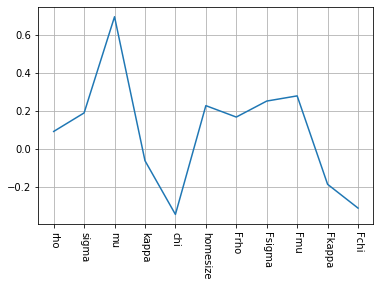

In [8]:
mu = muhist[trial]
plt.plot(mu / np.linalg.norm(mu))
plt.xticks(np.arange(11), variables, rotation=-90)
plt.grid()

In [9]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(mu, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2326.0631940364838
138.499


In [10]:
d1 = {}
d1['dethist'] = dethist
d1['acthist'] = acthist
d1['muhist'] = muhist
d1['traintime'] = traintime
d1['deaths'] = deaths
d1['iters'] = trainiters
d1['rewardhist'] = rewardhist
d1['mu'] = mu
d1['testtime'] = testtime
sio.savemat('trials_linear.mat', d1)

In [5]:
class multiLayer(nn.Module):
    def __init__(self, inputdim, hdims = None, outputdim=1):
        super(multiLayer, self).__init__()
        self.inputdim = inputdim
        hdims = list(hdims)
        self.hdims = hdims
        self.outputdim = outputdim
        dims = [inputdim]
        if len(hdims) > 0:
            dims = dims + hdims
        dims.append(outputdim)
        
        self.fcs = []
        for k in range(len(dims) - 1):
            self.fcs.append(nn.Linear(dims[k], dims[k + 1]))
        self.activation = nn.LeakyReLU(negative_slope=0.1)
        self.paramlength = len(self.getparams())
    def forward(self, x):
        out = x
        for k in range(len(self.fcs) - 1):
            #print(k)
            layer = self.fcs[k]
            out = layer(out)
            out = self.activation(out)
        out = self.fcs[-1](out)
        return out
    def getparams(self):
        ws = np.zeros(0)
        with torch.no_grad():
            for k in range(len(self.fcs)):
                w = self.fcs[k].weight.data
                ws = np.hstack((ws, w.flatten()))
            for k in range(len(self.fcs)):
                b = self.fcs[k].bias.data
                ws = np.hstack((ws, b.flatten()))
        return ws
    def setparams(self, weights):
        shapes = []
        bshapes = []
        with torch.no_grad():
            idx = 0
            for k in range(len(self.fcs)):
                shapes.append(self.fcs[k].weight.data.shape)
                bshapes.append(self.fcs[k].bias.data.shape)
            for k in range(len(self.fcs)):
                shape = shapes[k]
                L = np.prod(shape)
                w = weights[idx:idx+L].reshape(shape)
                self.fcs[k].weight.data.copy_(torch.FloatTensor(w))
                idx += L
            for k in range(len(self.fcs)):
                shape = bshapes[k]
                L = np.prod(shape)
                b = weights[idx:idx+L]
                self.fcs[k].bias.data.copy_(torch.FloatTensor(b))
                idx += L
        return

In [12]:
hdims = [5]

In [13]:
model = multiLayer(11, hdims, 1)
dim = model.paramlength
print(dim)
mu = np.zeros(dim)
sig = np.eye(dim)
precision = np.eye(dim)

66


In [14]:
numTrials = 10000

t0 = time.time()
baseline = -15
eps = 0.3
alpha = 0.001

dethist = np.zeros(numTrials)
acthist = np.zeros((numTrials, dim))
muhist = np.zeros((numTrials, dim))
rewardhist = np.zeros((numTrials))
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    #eps = 10/(10+trial)
    u = np.random.random()
    if u < eps:
        act = np.random.randn(dim)
    else:
        act = np.random.multivariate_normal(mu, sig)
    model = multiLayer(11, hdims, 1)
    model.setparams(act)
    reward = -env.trialEnv(model, Ninf_train, N_train, T_train, lam0_train)
    rewardhist[trial] = reward
    
    acthist[trial] = act
    muhist[trial] = mu
    sigdet = np.linalg.det(sig)
    dethist[trial] = sigdet
    #print(sigdet)
    
    siginv = np.linalg.inv(sig)
    
    alpha = 1/(1000 + trial)
    mu += alpha*(reward - baseline)*(siginv@(act - mu))
    amu = (act - mu).reshape((-1, 1))
    sigprime = sig + sigdet*alpha*(reward - baseline)*(-0.5*siginv + 0.5*siginv@amu@amu.T@siginv)
    if np.linalg.det(sigprime) < 1e-12:
        print('finished: ', trial)
        break
    else:
        sig = sigprime
traintime = time.time() - t0
trainiters = trial

0
100
200
finished:  276


In [15]:
model = multiLayer(11, hdims, 1)
mu = muhist[trial]
model.setparams(mu)
print(muhist[trial])

[-0.01415301 -0.06008325  0.22820497 -0.00883989 -0.10800197  0.06971574
 -0.00525483 -0.00732214  0.17696524  0.2857392  -0.0451375  -0.29921692
  0.11836879 -0.03322969 -0.07400459 -0.13381018  0.07176934 -0.05188675
  0.05051993  0.0076399  -0.02701508  0.01088821 -0.07831655 -0.22854915
  0.13670763 -0.22623837  0.24622007  0.08319167  0.27311099 -0.10574846
 -0.06934419 -0.2098367   0.01142175  0.13591387  0.11778407 -0.02765328
 -0.19302465  0.11275604 -0.06398864 -0.18494599  0.09297936 -0.27171297
  0.1608107   0.01424631  0.01323393 -0.1287213   0.25530666  0.39651095
 -0.08744232  0.04626657  0.28854239 -0.08642901  0.20093522 -0.25352052
 -0.27593173  0.15750829  0.33438427 -0.13560087  0.23848557  0.28383631
  0.0946665   0.29207263 -0.05790897  0.05423922  0.0664899   0.06651945]


In [16]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(model, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2490.8698937892914
155.045


In [17]:
d2 = {}
d2['dethist'] = dethist
d2['acthist'] = acthist
d2['muhist'] = muhist
d2['traintime'] = traintime
d2['deaths'] = deaths
d2['iters'] = trainiters
d2['rewardhist'] = rewardhist
d2['mu'] = mu
d2['testtime'] = testtime
sio.savemat('hdim_5_trials.mat', d2)

In [18]:
numTrials = 10000

t0 = time.time()
baseline = -15

acthist = np.zeros((numTrials, 11))
rewardhist = np.zeros(numTrials)
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    act = np.random.randn(11)
    act /= np.linalg.norm(act)
    reward = -env.trialEnv(act, Ninf_train, N_train, T_train, lam0_train)
    rewardhist[trial] = reward
    
    acthist[trial] = act
    
traintime = time.time() - t0
trainiters = trial

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [19]:
from sklearn.linear_model import LinearRegression as LR

In [20]:
lr = LR()

In [22]:
lr.fit(acthist, rewardhist)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
a = lr.coef_ / np.linalg.norm(lr.coef_)

[]

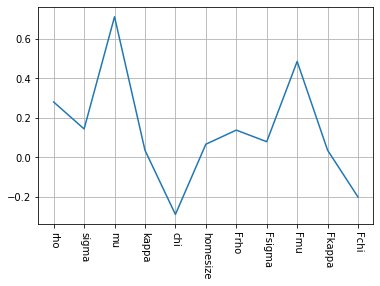

In [24]:
plt.plot(a)
plt.grid()
plt.xticks(np.arange(11), variables, rotation=-90)
plt.plot()

In [25]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(a, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2332.7164299488068
134.213


In [26]:
d3 = {}
d3['traintime'] = traintime
d3['iters'] = trainiters
d3['acthist'] = acthist
d3['rewardhist'] = rewardhist
d3['deaths'] = deaths
d3['a'] = a
d3['testtime'] = testtime
sio.savemat('least_squares.mat', d3)

In [27]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(None, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2134.0087761878967
211.397


In [28]:
d = {}
d['deaths'] = deaths
sio.savemat('randomvacc.mat', d)

In [29]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(None, Ninf_test, N_test, T_test, lam0_test, usevac=False)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2030.635308265686
259.596


In [30]:
d = {}
d['deaths'] = deaths
sio.savemat('novacc.mat', d)

In [31]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(None, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2142.495379924774
211.778


In [32]:
d4 = {}
d4['deaths'] = deaths
sio.savemat('randomvacc.mat', d4)

In [17]:
mu = np.zeros(11)
sig = np.eye(11)
precision = np.eye(11)

In [18]:
numTrials = 10000

t0 = time.time()
baseline = -15
eps = 0.3
alpha = 0.001

acthist = np.zeros((numTrials, 11))
muhist = np.zeros((numTrials, 11))
rewardhist = np.zeros(numTrials)
sig = 0.1*np.eye(11)
siginv = np.linalg.inv(sig)
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    u = np.random.random()
    if u < eps:
        act = np.random.randn(11)
        #act /= np.linalg.norm(act)
    else:
        act = np.random.multivariate_normal(mu, sig)
        #act /= np.linalg.norm(act)
    reward = -env.trialEnv(act, Ninf_train, N_train, T_train, lam0_train)
    rewardhist[trial] = reward
    
    acthist[trial] = act
    muhist[trial] = mu
    
    alpha = 1/(1000 + trial)
    mu += alpha*(reward - baseline)*(act - mu)
    amu = (act - mu).reshape((-1, 1))
traintime = time.time() - t0
trainiters = trial

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [ ]:
muhist[trial]

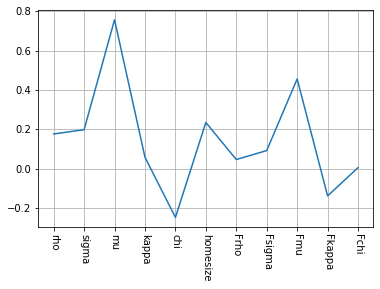

In [19]:
mu = muhist[trial]
plt.plot(mu / np.linalg.norm(mu))
plt.xticks(np.arange(11), variables, rotation=-90)
plt.grid()

In [20]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(mu, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
2416.6292095184326
137.175


In [21]:
d5 = {}
d5['acthist'] = acthist
d5['muhist'] = muhist
d5['traintime'] = traintime
d5['deaths'] = deaths
d5['iters'] = trainiters
d5['rewardhist'] = rewardhist
d5['mu'] = mu
d5['testtime'] = testtime
sio.savemat('trials_linear_fixedsig2.mat', d5)

In [13]:
hdims = [5]

In [14]:
model = multiLayer(11, hdims, 1)
dim = model.paramlength
print(dim)
mu = np.zeros(dim)
sig = np.eye(dim)
precision = np.eye(dim)

66


In [15]:
numTrials = 10000

t0 = time.time()
baseline = -15
eps = 0.3
alpha = 0.001

acthist = np.zeros((numTrials, dim))
muhist = np.zeros((numTrials, dim))
rewardhist = np.zeros((numTrials))

sig = 0.1*np.eye(dim)
siginv = np.linalg.inv(sig)

for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    #eps = 10/(10+trial)
    u = np.random.random()
    if u < eps:
        act = np.random.randn(dim)
    else:
        act = np.random.multivariate_normal(mu, sig)
    model = multiLayer(11, hdims, 1)
    model.setparams(act)
    reward = -env.trialEnv(model, Ninf_train, N_train, T_train, lam0_train)
    rewardhist[trial] = reward
    
    acthist[trial] = act
    muhist[trial] = mu
    #print(sigdet)
    
    alpha = 1/(1000 + trial)
    mu += alpha*(reward - baseline)*(act - mu)
traintime = time.time() - t0
trainiters = trial

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [16]:
model = multiLayer(11, hdims, 1)
mu = muhist[trial]
model.setparams(mu)
print(muhist[trial])

[ 3.0056607  -1.6790594  -0.93482616  2.29251957 -4.49664161 -0.70300698
  2.28224622  1.86484291 -7.76612283 -0.51941136 -4.83530908  1.43314509
 -1.08649377 -7.42598411  1.19923538 -3.03147338 -4.827699    1.16025168
 -1.88861846 -1.92452954 -4.40237416  0.49423051  0.43725488 -2.49520898
 -3.41502454 -1.61374612  1.04514515  1.84060791  7.62283453 -7.94984035
 -6.20402826  5.59730884  4.56440561 -4.28498559  3.50396155  7.78749132
 -0.69696578 -8.52216878 -1.94607942  5.32476109 -3.6386774   5.58245472
  2.63331176 -2.52658777  4.35678642 -4.10136758 -2.73177316 -5.85254552
 -3.14308998 -3.06193371  5.65867926 -3.55211676  1.58225724 -0.29158866
 -9.1118297   9.52052303  0.63625482  3.54377737 10.23859103  4.93296712
 -2.25910064  7.73483578  5.66088994  0.40510323  0.5606841   3.265942  ]


In [17]:
numTrials = 1000
deaths = np.zeros(numTrials)

t0 = time.time()
for trial in range(numTrials):
    if trial % 100 == 0:
        print(trial)
    deaths[trial] = env.trialEnv(model, Ninf_test, N_test, T_test, lam0_test)
testtime = time.time() - t0
print(testtime)
print(np.mean(deaths))

0
100
200
300
400
500
600
700
800
900
3259.066739797592
156.569


In [18]:
d6 = {}
d6['acthist'] = acthist
d6['muhist'] = muhist
d6['traintime'] = traintime
d6['deaths'] = deaths
d6['iters'] = trainiters
d6['rewardhist'] = rewardhist
d6['mu'] = mu
d6['testtime'] = testtime
sio.savemat('hdim_5_trials_fixedsig.mat', d6)

In [19]:
traintime / 60

58.63776959180832